## Data & preprocessing

In [1]:
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split

X, y, meta_data = load_classification("AsphaltPavementTypeCoordinates")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## X-ROCKET encoder

In [2]:
from xrocket import XRocket
from torch import Tensor

encoder = XRocket(in_channels=3, max_kernel_span=100, combination_order=1, feature_cap=10_000)
encoder.fit(Tensor(X_train[0]).unsqueeze(0))

In [3]:
embed_train, embed_test = [], []
for x in X_train:
    embed_train.append(encoder(Tensor(x).unsqueeze(0)))
for x in X_test:
    embed_test.append(encoder(Tensor(x).unsqueeze(0)))

In [4]:
from torch import concat
import pandas as pd

feature_names = pd.Index(encoder.feature_names).rename(["pattern", "dilation", "channel", "threshold"])
embed_train = pd.DataFrame(data=concat(embed_train), columns=feature_names)
embed_test = pd.DataFrame(data=concat(embed_test), columns=feature_names)

## Prediction head

In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(embed_train, y_train)

RandomForestClassifier()

In [6]:
from sklearn.metrics import accuracy_score

pred_train, pred_test = model.predict(embed_train), model.predict(embed_test)
acc_train, acc_test = accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test)

## Feature importances

In [7]:
feature_importances = pd.Series(data=model.feature_importances_, index=feature_names)

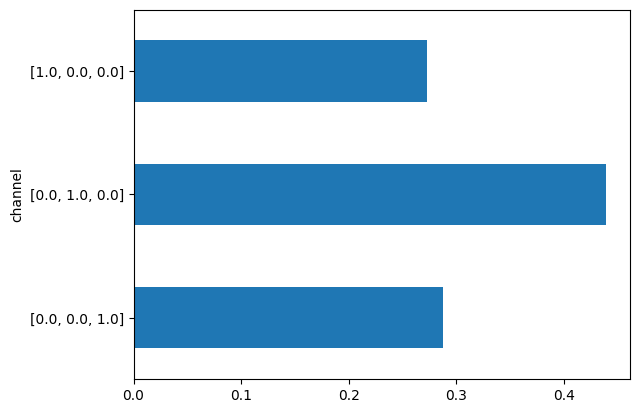

In [8]:
channel_importances = feature_importances.abs().groupby("channel").sum()
ax = channel_importances.plot(kind="barh")

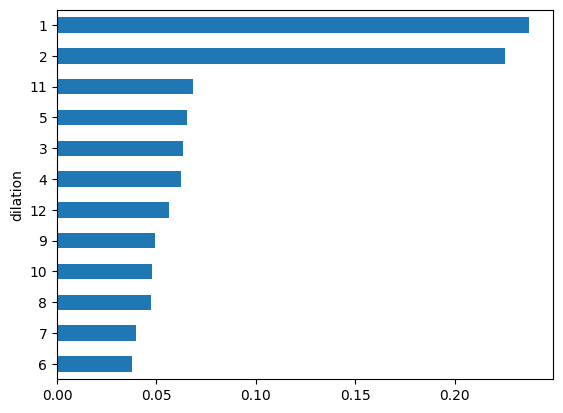

In [9]:
dilation_importances = feature_importances.groupby("dilation").sum().sort_values()
ax = dilation_importances.plot(kind="barh")

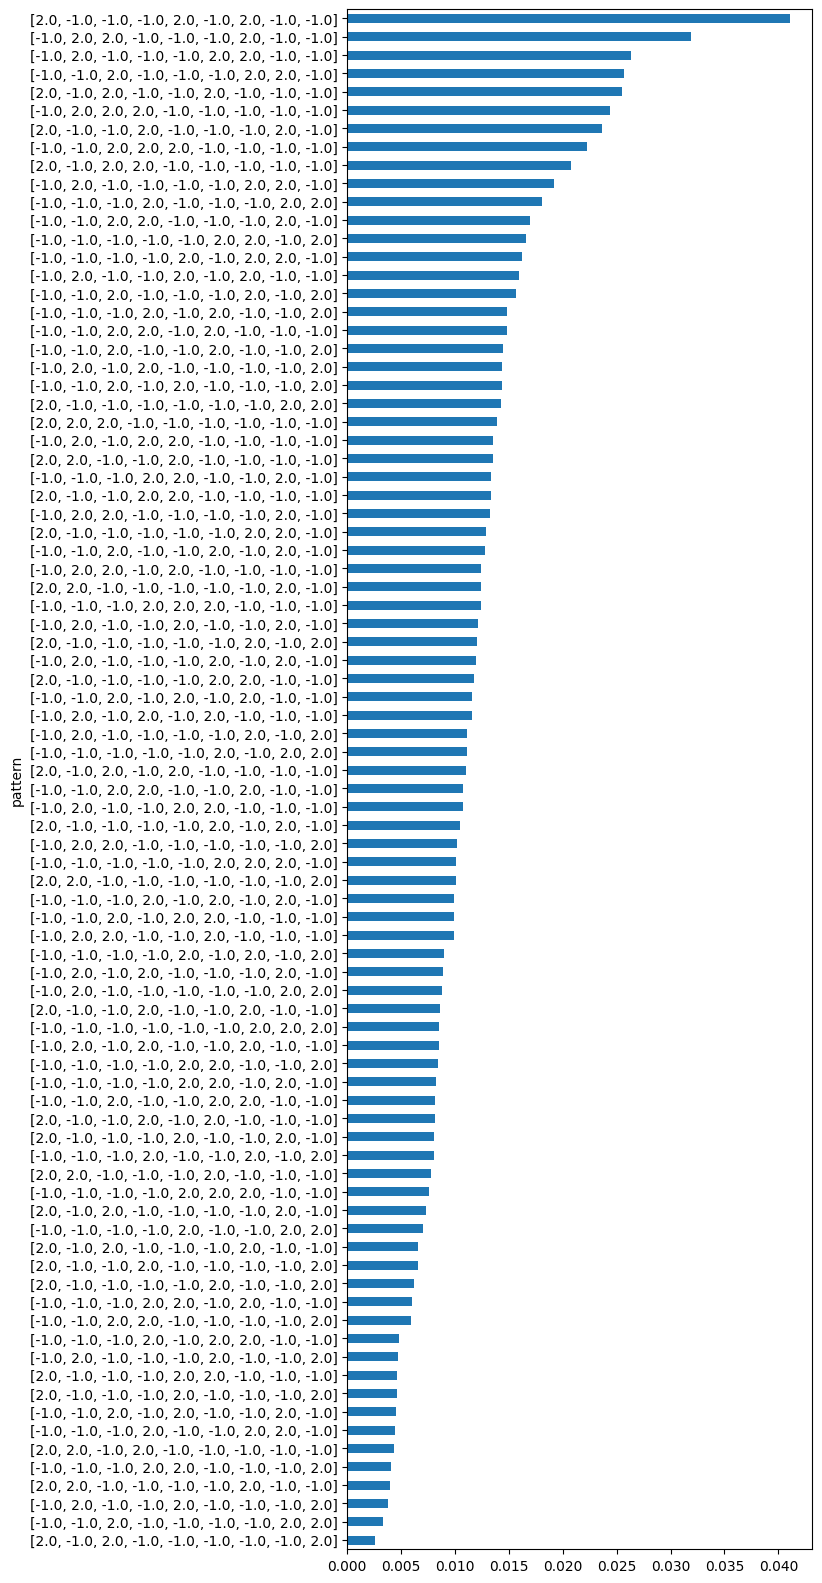

In [10]:
pattern_importances = feature_importances.groupby("pattern").sum().sort_values()
ax = pattern_importances.plot(kind="barh", figsize=(6,20))
